<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if not "train" in os.listdir():
  !unzip -q /content/drive/MyDrive/forestModel/trainForest128.zip -d train

In [4]:
def get_dataloader(batch_size, dataDir, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  transform = tt.Compose([
      tt.ToTensor(),
      tt.Normalize(*stats)
  ])
  # TODO: resize images, convert them to tensors and build dataloader
  train_dataset = ImageFolder(root = dataDir, transform = transform)
  loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 2, pin_memory=True)
  originalImage=[]
  for data, _ in loader:
    originalImage.append(data)
  trainD = torch.cat(originalImage, dim=0)
  print(trainD.shape)
  trainLoader = torch.utils.data.DataLoader(trainD, batch_size, shuffle = True, num_workers = 2, pin_memory=True)
  return trainLoader

In [5]:
batchSize = 16
trainDir = "/content/train"
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
dataLoader = get_dataloader(batchSize, trainDir, stats)
#TODO: build dataloader and transfer it to device

torch.Size([2952, 3, 128, 128])


In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def showImage(image, quantityImage):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(image.detach()[:quantityImage]), nrow=8).permute(1, 2, 0))
  fig.show()

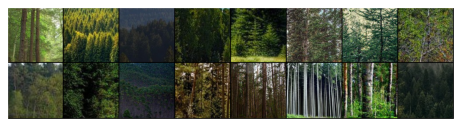

In [8]:
data = next(iter(dataLoader))
showImage(data.cpu(), 32)

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
dataLoader = DeviceDataLoader(dataLoader, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [12]:
class AddNoise(nn.Module):
    def __init__(self, noise_factor):
        super(AddNoise, self).__init__()
        self.noise_factor = noise_factor

    def forward(self, x):
        X_noisy = x + self.noise_factor * torch.from_numpy(np.random.normal(loc=0.0, scale=1.0, size=x.shape)).to(device)
        return X_noisy.to(torch.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


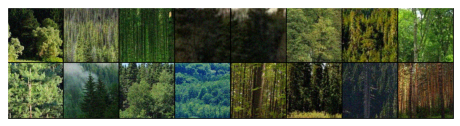

In [13]:
data = next(iter(dataLoader))
noise = nn.Sequential(
    AddNoise(0.1)
)
noise = noise.to(device)
X_noisy = noise(data)
showImage(X_noisy.cpu(), 32)

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    AddNoise(0.1),
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4


    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

## 2.1 Генератор

In [16]:
class ConvTransposeLayer(nn.Module):
    def __init__(self, inputChanels, outputChanels, kernelSize = 3, stride = 1, padding = 1, *args):
        super(ConvTransposeLayer, self).__init__()
        self.shape = args
        self.step = nn.Sequential(
            nn.ConvTranspose2d(inputChanels, outputChanels, kernelSize, stride, padding, bias=False),
            nn.BatchNorm2d(outputChanels),
            nn.LeakyReLU()
            )
    def forward(self, x):
        return self.step(x)

In [17]:
class ConvLayer(nn.Module):
    def __init__(self, inputChanels, outputChanels, kernelSize = 3, stride = 1, padding = 1, *args):
        super(ConvLayer, self).__init__()
        self.shape = args
        self.step = nn.Sequential(
            nn.Conv2d(inputChanels, outputChanels, kernelSize, stride, padding, bias=False),
            nn.BatchNorm2d(outputChanels),
            nn.LeakyReLU()
            )
    def forward(self, x):
        return self.step(x)

In [18]:
class UnificationLayer(nn.Module):
    def __init__(self, inOutputChanels):
        super(UnificationLayer, self).__init__()
        intermediateChanels = int(inOutputChanels / 2)
        self.step = nn.Sequential(
            ConvTransposeLayer(inOutputChanels, intermediateChanels, kernelSize = 4, stride = 2, padding = 1),
            ConvLayer(intermediateChanels, inOutputChanels, kernelSize = 4, stride = 2, padding = 1)
        )
    def forward(self, x):
        conv = self.step(x);
        output = conv + x
        return output

In [19]:
class UpSize(nn.Module):
    def __init__(self, inputChanels, outputChanels, numberRepettions):
        super(UpSize, self).__init__()
        self.numberRepettions = numberRepettions
        self.updateLayer = ConvTransposeLayer(inputChanels, outputChanels, kernelSize = 4, stride = 2, padding = 1)
        self.unificationLayer = UnificationLayer(outputChanels)
    def forward(self, x):
        updateX = self.updateLayer(x)
        for i in range(self.numberRepettions):
          updateX = self.unificationLayer(updateX)
        return updateX

In [20]:
class Generator(nn.Module):
    def __init__(self, latentSize, *args):
        super(Generator, self).__init__()
        
        self.layer1 = ConvTransposeLayer(latentSize, 1024, kernelSize = 4, stride = 2, padding = 0) # 1 to 4
        self.layer2 = UpSize(1024, 512, numberRepettions = 2) # 4 to 8
        self.layer3 = UpSize(512, 256, numberRepettions = 2) # 8 to 16
        self.layer4 = UpSize(256 + 512, 128, numberRepettions = 3) # 16 to 32
        self.layer5 = UpSize(128 + 256 + 512, 64, numberRepettions = 5) # 32 to 64
        self.layer6 = UpSize(64 + 128 + 256, 32, numberRepettions = 7) # 64 to 128

        self.outputLayer = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size = 3, stride = 1, padding = 1),
            nn.Tanh()
        )

        self.upsampleScale2 = nn.Upsample(scale_factor = 2, mode = 'nearest')

    def forward(self, x):
        fromLayer1 = self.layer1(x)
        fromLayer2 = self.layer2(fromLayer1)
        fromLayer3 = self.layer3(fromLayer2)

        fromLayer2 = self.upsampleScale2(fromLayer2)
        toLayer4 = torch.cat([fromLayer3, fromLayer2], dim = 1)

        fromLayer4 = self.layer4(toLayer4)

        fromLayer2 = self.upsampleScale2(fromLayer2)
        fromLayer3 = self.upsampleScale2(fromLayer3)
        toLayer5 = torch.cat([fromLayer4, fromLayer3, fromLayer2], dim =1)

        fromLayer5 = self.layer5(toLayer5)

        fromLayer3 = self.upsampleScale2(fromLayer3)
        fromLayer4 = self.upsampleScale2(fromLayer4)
        toLayer6 = torch.cat([fromLayer5, fromLayer4, fromLayer3], dim = 1)

        fromLayer6 = self.layer6(toLayer6)
        outImage = self.outputLayer(fromLayer6)

        return outImage

In [21]:
latent_size = 128 # choose latent size
generator_ = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [22]:
latent_size = 128 # choose latent size
newGenerator = Generator(latent_size)
generator = to_device(newGenerator, device)

torch.Size([16, 3, 128, 128])


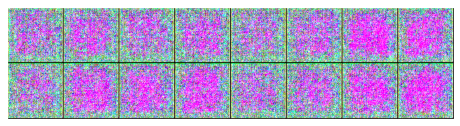

In [23]:
xb = torch.randn(batchSize, latent_size, 1, 1) 
fake_images = generator(xb.to(device))
print(fake_images.shape)
showImage(fake_images.cpu(), 32)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [24]:
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output

In [25]:
def showGenerateImage(generator, latentSpace):
  generateImages = generator(latentSpace)
  showImage(generateImages.cpu(), latentSpace.shape[0])

In [26]:
def drawLossGrafiks(diskriminatorLoss, generatorLoss):
  plt.figure(figsize=(10, 5))
  plt.plot(diskriminatorLoss, '-')
  plt.plot(generatorLoss, '-')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Discriminator', 'Generator'])
  plt.title('Losses')
  plt.show()

In [27]:
def drawScoreGrafiks(realScore, fakeScore):
  plt.figure(figsize=(10, 5))
  plt.plot(realScore, '-')
  plt.plot(fakeScore, '-')
  plt.xlabel('epoch')
  plt.ylabel('score')
  plt.legend(['Real', 'Fake'])
  plt.title('Scores')
  plt.show()

In [28]:
def generateFakeImage(generator, quantityImage):
  latent = torch.randn(quantityImage, latent_size, 1, 1, device=device)
  fakeImages = generator(latent)
  return fakeImages

In [29]:
def fitDiscriminator(discriminator, generator, criterion, optimizer, realImages):

  optimizer.zero_grad()
  
  # Pass real images through discriminator
  realPredict = discriminator(realImages)
  realTarget = torch.ones(realImages.size(0), 1, device=device)
  realLoss = criterion(realPredict, realTarget)
  curentRealScore = torch.mean(realPredict).item()
  
  # Generate fake images
  fakeImages = generateFakeImage(generator, realImages.size(0))
  
  # Pass fake images through discriminator
  fakePredict = discriminator(fakeImages)
  fakeTarget = torch.zeros(realImages.size(0), 1, device=device)
  fakeLoss = criterion(fakePredict, fakeTarget)
  curentFakeScore = torch.mean(fakePredict).item()
  
  # Update discriminator weights
  loss = (realLoss + fakeLoss)
  loss.backward()
  optimizer.step()
  return curentRealScore, curentFakeScore, loss

In [30]:
def fitGenerator(discriminator, generator, criterion, optimizer, quantityImage):

  optimizer.zero_grad()
  # Generate fake images
  fakeImages = generateFakeImage(generator, quantityImage)
  # Try to fool the discriminator
  predict = discriminator(fakeImages)
  target = torch.ones(quantityImage, 1, device=device)
  loss = criterion(predict, target)
  generatorScore = torch.mean(predict).item()
  # Update generator weights
  loss.backward()
  optimizer.step()
  return loss, generatorScore

In [31]:
def fitEpoch(model, criterion, optimizer, dataLoader):
  realScorePerEpoch = []
  fakeScorePerEpoch = []
  lossDiscriminotorPerEpoch = []
  lossGeneratorPerEpoch = []
  generatorScorePerEpoch = []

  for realImages in dataLoader:
    curentRealScore, curentFakeScore, lossDiscriminator = fitDiscriminator(model["discriminator"], model["generator"], criterion["discriminator"], optimizer["discriminator"], realImages)
    lossGenerator, generatorScore = fitGenerator(model["discriminator"], model["generator"], criterion["generator"], optimizer["generator"], realImages.size(0))

    # Write history
    lossDiscriminotorPerEpoch.append(lossDiscriminator.item())
    lossGeneratorPerEpoch.append(lossGenerator.item())
    realScorePerEpoch.append(curentRealScore)
    fakeScorePerEpoch.append(curentFakeScore)
    generatorScorePerEpoch.append(generatorScore)
  return realScorePerEpoch, fakeScorePerEpoch, lossDiscriminotorPerEpoch, lossGeneratorPerEpoch

In [32]:
def initialize_wieghts(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [33]:
def fit(model, criterion, optimizer, maxEpochs, weigthInit =False):
  # TODO: build optimizers and train your GAN
  if weigthInit:
    initialize_wieghts(model["generator"])
    initialize_wieghts(model["discriminator"])
  model["generator"].train()
  model["discriminator"].train()
  
  quantityTestImage = 32
  fixedLatent = torch.randn(quantityTestImage, latent_size, 1, 1, device=device)

  lossesGenerator = []
  lossesDiscriminator = []
  realScore = []
  fakeScore = []

  log_template = "\nEpoch {ep:03d} lossesGenerator: {lossesG:0.4f} lossesDiscriminator {lossesD:0.4f}"
  
  with tqdm(desc="epoch", total=maxEpochs) as pbar_outer:
    for epoch in range(maxEpochs):
      realScorePerEpoch, fakeScorePerEpoch, lossDiscriminotorPerEpoch, lossGeneratorPerEpoch = fitEpoch(model, criterion, optimizer, dataLoader)
      
      lossesGenerator.append(np.mean(lossGeneratorPerEpoch))
      lossesDiscriminator.append(np.mean(lossDiscriminotorPerEpoch))
      realScore.append(np.mean(realScorePerEpoch))
      fakeScore.append(np.mean(fakeScorePerEpoch))

      clear_output(wait=True)
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, lossesG=np.mean(lossGeneratorPerEpoch), lossesD=np.mean(lossDiscriminotorPerEpoch)))
      showGenerateImage(model['generator'], fixedLatent)
      drawLossGrafiks(lossesDiscriminator, lossesGenerator)
      drawScoreGrafiks(realScore, fakeScore)
    


In [34]:
lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
}


In [ ]:
discriminator = to_device(discriminator, torch.device('cpu'))
generator = to_device(generator, torch.device('cpu'))
del generator
del discriminator

epoch:  71%|███████   | 71/100 [3:42:11<1:30:43, 187.72s/it]


Epoch 071 lossesGenerator: 9.5834 lossesDiscriminator 0.2770


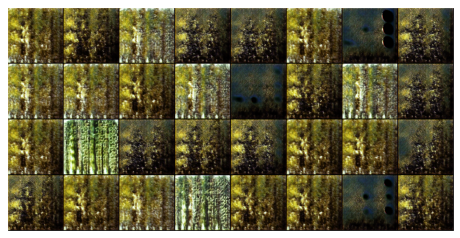

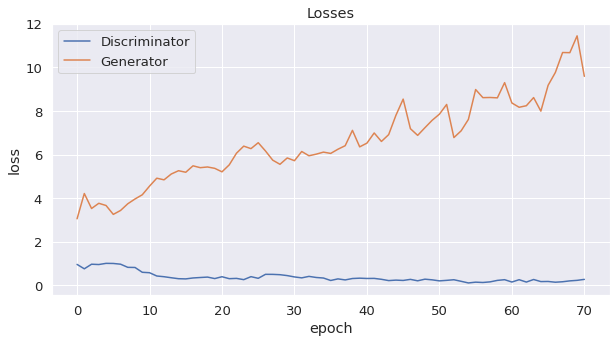

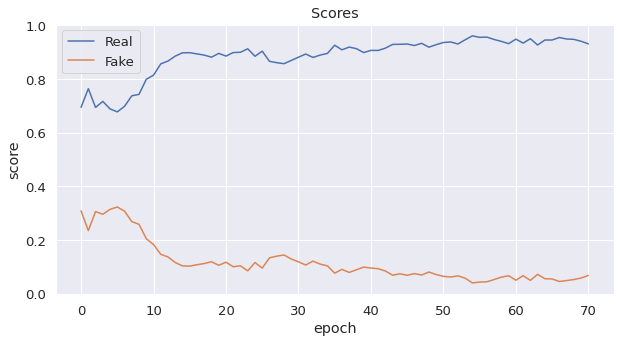

In [ ]:
fit(model, criterion, optimizer, 100, True)

In [ ]:
torch.save(model["generator"].state_dict(), '/content/drive/MyDrive/models/forest/generator_100_v2_0.pth')
torch.save(model["discriminator"].state_dict(), '/content/drive/MyDrive/models/forest/discriminator_100_v2_0.pth')

In [ ]:
model["generator"].load_state_dict(torch.load('/content/drive/MyDrive/models/gan_gen_100_v1_0.pth'))
model["discriminator"].load_state_dict(torch.load('/content/drive/MyDrive/models/gan_dis_100_v1_0.pth'))

epoch: 100%|██████████| 100/100 [1:08:36<00:00, 41.25s/it]


Epoch 100 lossesGenerator: 7.5267 lossesDiscriminator 0.2093


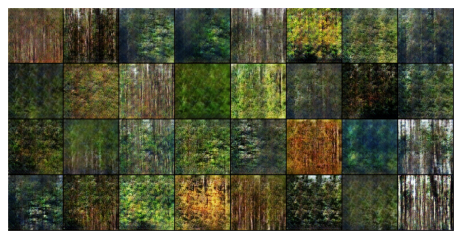

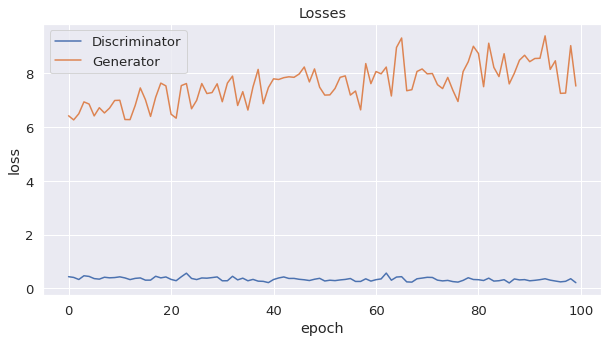

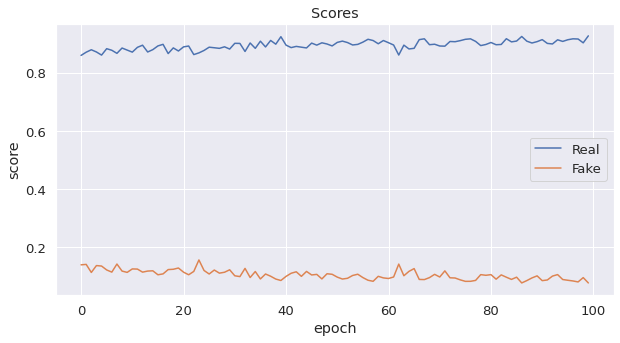

epoch: 100%|██████████| 100/100 [1:08:37<00:00, 41.18s/it]


In [ ]:
fit(model, criterion, optimizer, 100, False)

In [ ]:
torch.save(model["generator"].state_dict(), '/content/drive/MyDrive/models/forest/gan_gen_200_v1_0.pth')
torch.save(model["discriminator"].state_dict(), '/content/drive/MyDrive/models/forest/gan_dis_200_v1_0.pth')

In [ ]:
model["generator"].load_state_dict(torch.load('/content/drive/MyDrive/models/gan_gen_200_v1_0.pth'))
model["discriminator"].load_state_dict(torch.load('/content/drive/MyDrive/models/gan_dis_200_v1_0.pth'))

<All keys matched successfully>

epoch: 100%|██████████| 100/100 [1:08:42<00:00, 41.20s/it]


Epoch 100 lossesGenerator: 12.2042 lossesDiscriminator 0.2493


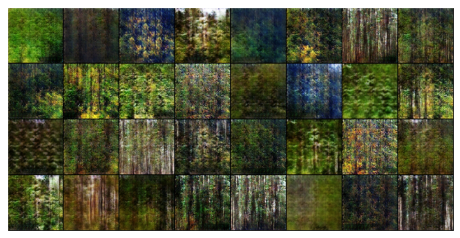

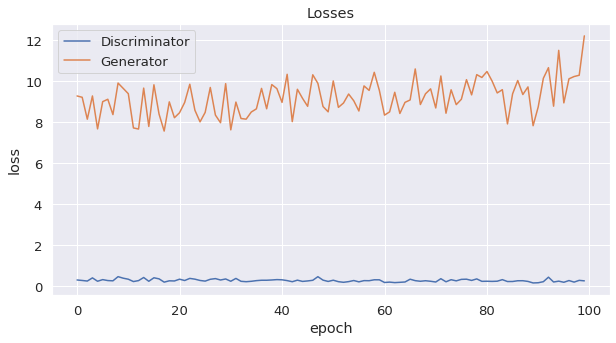

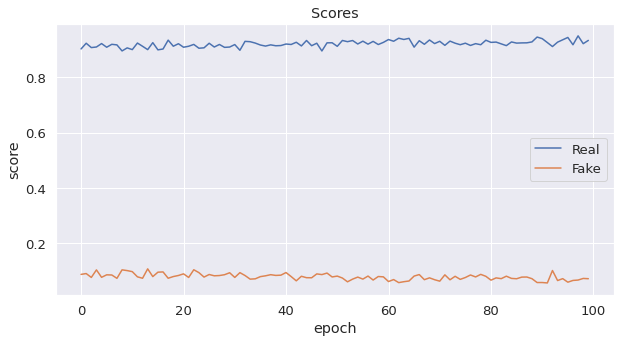

epoch: 100%|██████████| 100/100 [1:08:42<00:00, 41.23s/it]


In [ ]:
fit(model, criterion, optimizer, 100, False)

In [ ]:
torch.save(model["generator"].state_dict(), '/content/drive/MyDrive/models/forest/gan_gen_300_v1_0.pth')
torch.save(model["discriminator"].state_dict(), '/content/drive/MyDrive/models/forest/gan_dis_300_v1_0.pth')

In [ ]:
model["generator"].load_state_dict(torch.load('/content/drive/MyDrive/models/gan_gen_300_v1_0.pth'))
model["discriminator"].load_state_dict(torch.load('/content/drive/MyDrive/models/gan_dis_300_v1_0.pth'))

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Графики достаточно близки к теоретическим, так ошибка дискриминатора изначально была мала, после увеличило свое значение(примерно до 20-й эпохи) и затем началось её уменьшение. Ошибка же генератра изначально была большой, затем резко уменьшилось, продолжило плавное уменьшение (примерно до 70 эпохи) и сново пошла в рост.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

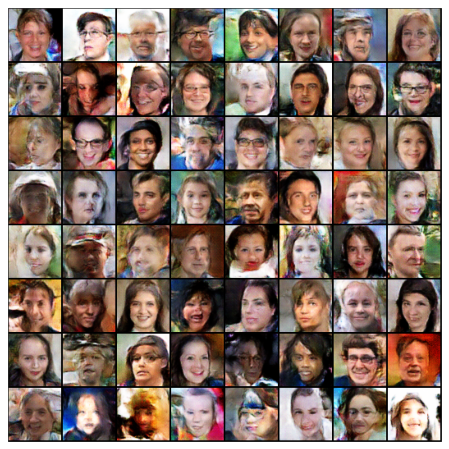

In [ ]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
model["generator"].eval()
showGenerateImage(model["generator"], fixed_latent)

Как вам качество получившихся изображений?

Есть единичные изображения похожие на реальных людей, но в целом генерируемые лица легко отличимы от реальных. Возможные решения - увеличения датасета, усложнение архитектуры генератора, увеличение времени обучения

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

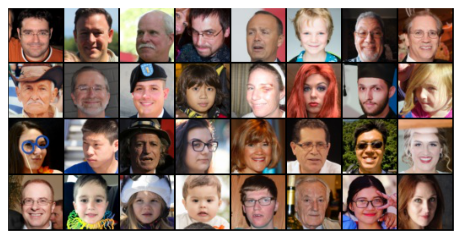

In [ ]:
originalImages = []
for data in dataLoader:
    originalImages.append(data.cpu())
originalImages = torch.cat((originalImages), 0)[:1000]
originalTarget = torch.ones(len(originalImages), 1)
showImage(originalImages, 32)

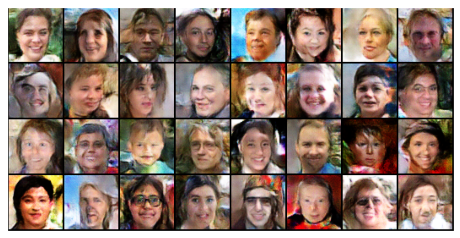

In [ ]:
quantityImages = len(originalImages)
fakeImages = generateFakeImage(model["generator"], quantityImages)
fakeTarget = torch.zeros(len(originalImages), 1)
showImage(fakeImages.cpu(), 32)

In [ ]:
X = np.concatenate((originalImages.detach().cpu().numpy(), fakeImages.detach().cpu().numpy()), 0)
Y = np.concatenate((originalTarget.detach().numpy(), fakeTarget.detach().numpy()), 0)

In [ ]:
X = np.resize(X, (X.shape[0], -1))
Y = np.resize(Y, (Y.shape[0]))

In [ ]:
loo = LeaveOneOut()

accuracy = []
for train_index, test_index in loo.split(X):
  knn = KNeighborsClassifier(1)
  xTrain = X[train_index]
  yTrain = Y[train_index]
  knn.fit(xTrain, yTrain)
  accuracy.append(accuracy_score(Y[test_index], knn.predict(X[test_index])))

In [ ]:
np.mean(accuracy)

0.806

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Результаты подтверждают написанное выше. Т.е. есть сгенерированные изображения которые близки к реальным однако большинство лекго отличимы. Идельным значением должно быть число 0.5.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


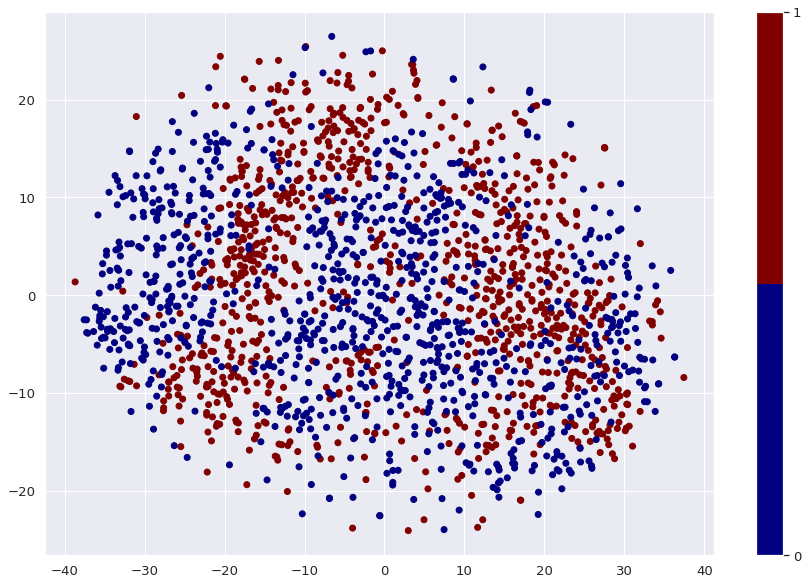

In [ ]:
latent = []
label = []
downSpace = TSNE()
downLatent = downSpace.fit_transform(X)

plt.figure(figsize=(15, 10))
plt.scatter(downLatent[:,0], downLatent[:,1], c = Y, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.show();

Прокомментируйте получившийся результат:

Опять же наблюдаем, что в целом значения реальных и сгенерированных изображений перемешанны между собой, но при этом большая часть сгенерированных расположенны достаточно близко друг к другу